# Deep Hedging AI: Comparison to Black & Scholes

In this notebook we run Deep Hedging in a Black & Scholes world
_without statistical drift_. In this case we can compare hedging a vanilla call vs its perfect hedge.

### Proof that Deep Hedging should converge to the Black & Scholes price

We are using the notation from the mark down file https://github.com/hansbuehler/deephedging.
Let $Z_T$ be the claim in $T$. Assume that there are no trading cost and that the market is _complete_. This applies to Black & Scholes, and also to most other models typically used in quant finance.
In the limit of $dt\downarrow 0$ that menas there is a perfect replication strateg $\alpha^*$ such that
$$
    (*) \ \ \ \ Z_T \equiv z_0 + \sum_{t=0}^{T-1} \alpha_t^*(s_t)\ ( H_T - H_t)
$$
The constant $z_0$ is the risk-neutral price of $Z_T$.

Consider now our risk-adjusted return metric $U$ as used in Deep Hedging. We are trying to compute
$$
    \sup_a:\ U\left[\ Z_T + \sum_{t=0}^{T-1} a_t(s_t)\ ( H_T - H_t)\ \right]
$$
We now insert $(*)$ for $Z_T$. That gives
$$
    \sup_a:\ U\left[\ z_0 + \sum_{t=0}^{T-1} \alpha_t^*(s_t)\ ( H_T - H_t) + \sum_{t=0}^{T-1} a_t(s_t)\ ( H_T - H_t)\ \right]
$$
Because of _cash-invariance_ we can move $z_0$ out of $U$.
$$
(**) \ \ \ \    z_0 + \sup_a:\ U\left[\ \sum_{t=0}^{T-1} \left( \alpha_t^*(s_t) - a_t(s_t) \right)\ ( H_T - H_t) \ \right]
$$
In case that the underlying path generator is a risk-neutral measure we get $\mathrm{E}_t[ H_T - H_t ] = 0$ and therefore that $\mathrm{E}_t[ x_t(a_t) ( H_T - H_t)  ]=0$ for any possible strategy $x$.
Moreover, because $U$ has the property that $U(X) \leq E[X]$ we see that an optimal solutio for $(**)$ is achived in
$$
    a_t = -\alpha^*_t
$$
which means that the optimal solution to the Deep Hedging problem for _any_ monetary utility is the risk-neutral strategy.
We also note that the utility of $Z_T$ under the Deep Hedging is
$
z_0 + U(0) = z_0 
$
in other words it returns the risk-neutral price as well.

### Questions

* *Why are the hedges for vanilla options not limited by -1/+1:* the hedging signal from Deep Hedging is an interpolation. In the grapsh below we show both the hedge per one of the 10,000 path, and a binned interpolation. In order to increase precision, a bigger network needs to be trained. It is important to notice that the noise does not impede the quality of the hedge when measures via the utility $U$.
* *How does that compare to the results in the Deep Hedging paper:* in that paper we artificially restricted delta to -1/+1. This should have been noted in the model.

In [1]:
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


In [2]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world_bs import SimpleWorld_BS

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20       # 20 weekly steps
config.world.dt = 5./250.     # """
config.world.drift = 0.       # no drift
config.world.cost = 0.        # no cost
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 0.5
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = 2000
config.trainer.train.epochs = 800 * config.trainer.train("batch_size")//32
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

config_small_dt = config.copy()
config_small_dt.world.steps = 20*5  # 100 daily steps
config_small_dt.world.dt = 1./250.  # """

Deep Hedging AI says hello  ... 

2023-01-23 20:56:17.101828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 20:56:17.305846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-23 20:56:19.682419: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-23 20:56:19.682491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World - Big Steps

2023-01-23 20:56:20.895779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym with 944 trainable weights compiled and initialized. Took 3s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/3654460ec08215c71e862f01bb5d3bbb.pck'
Cache successfully loaded. Current epoch: 50000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/3654460ec08215c71e862f01bb5d3bbb.pck was trained for 50000 epochs; you have asked to train fo

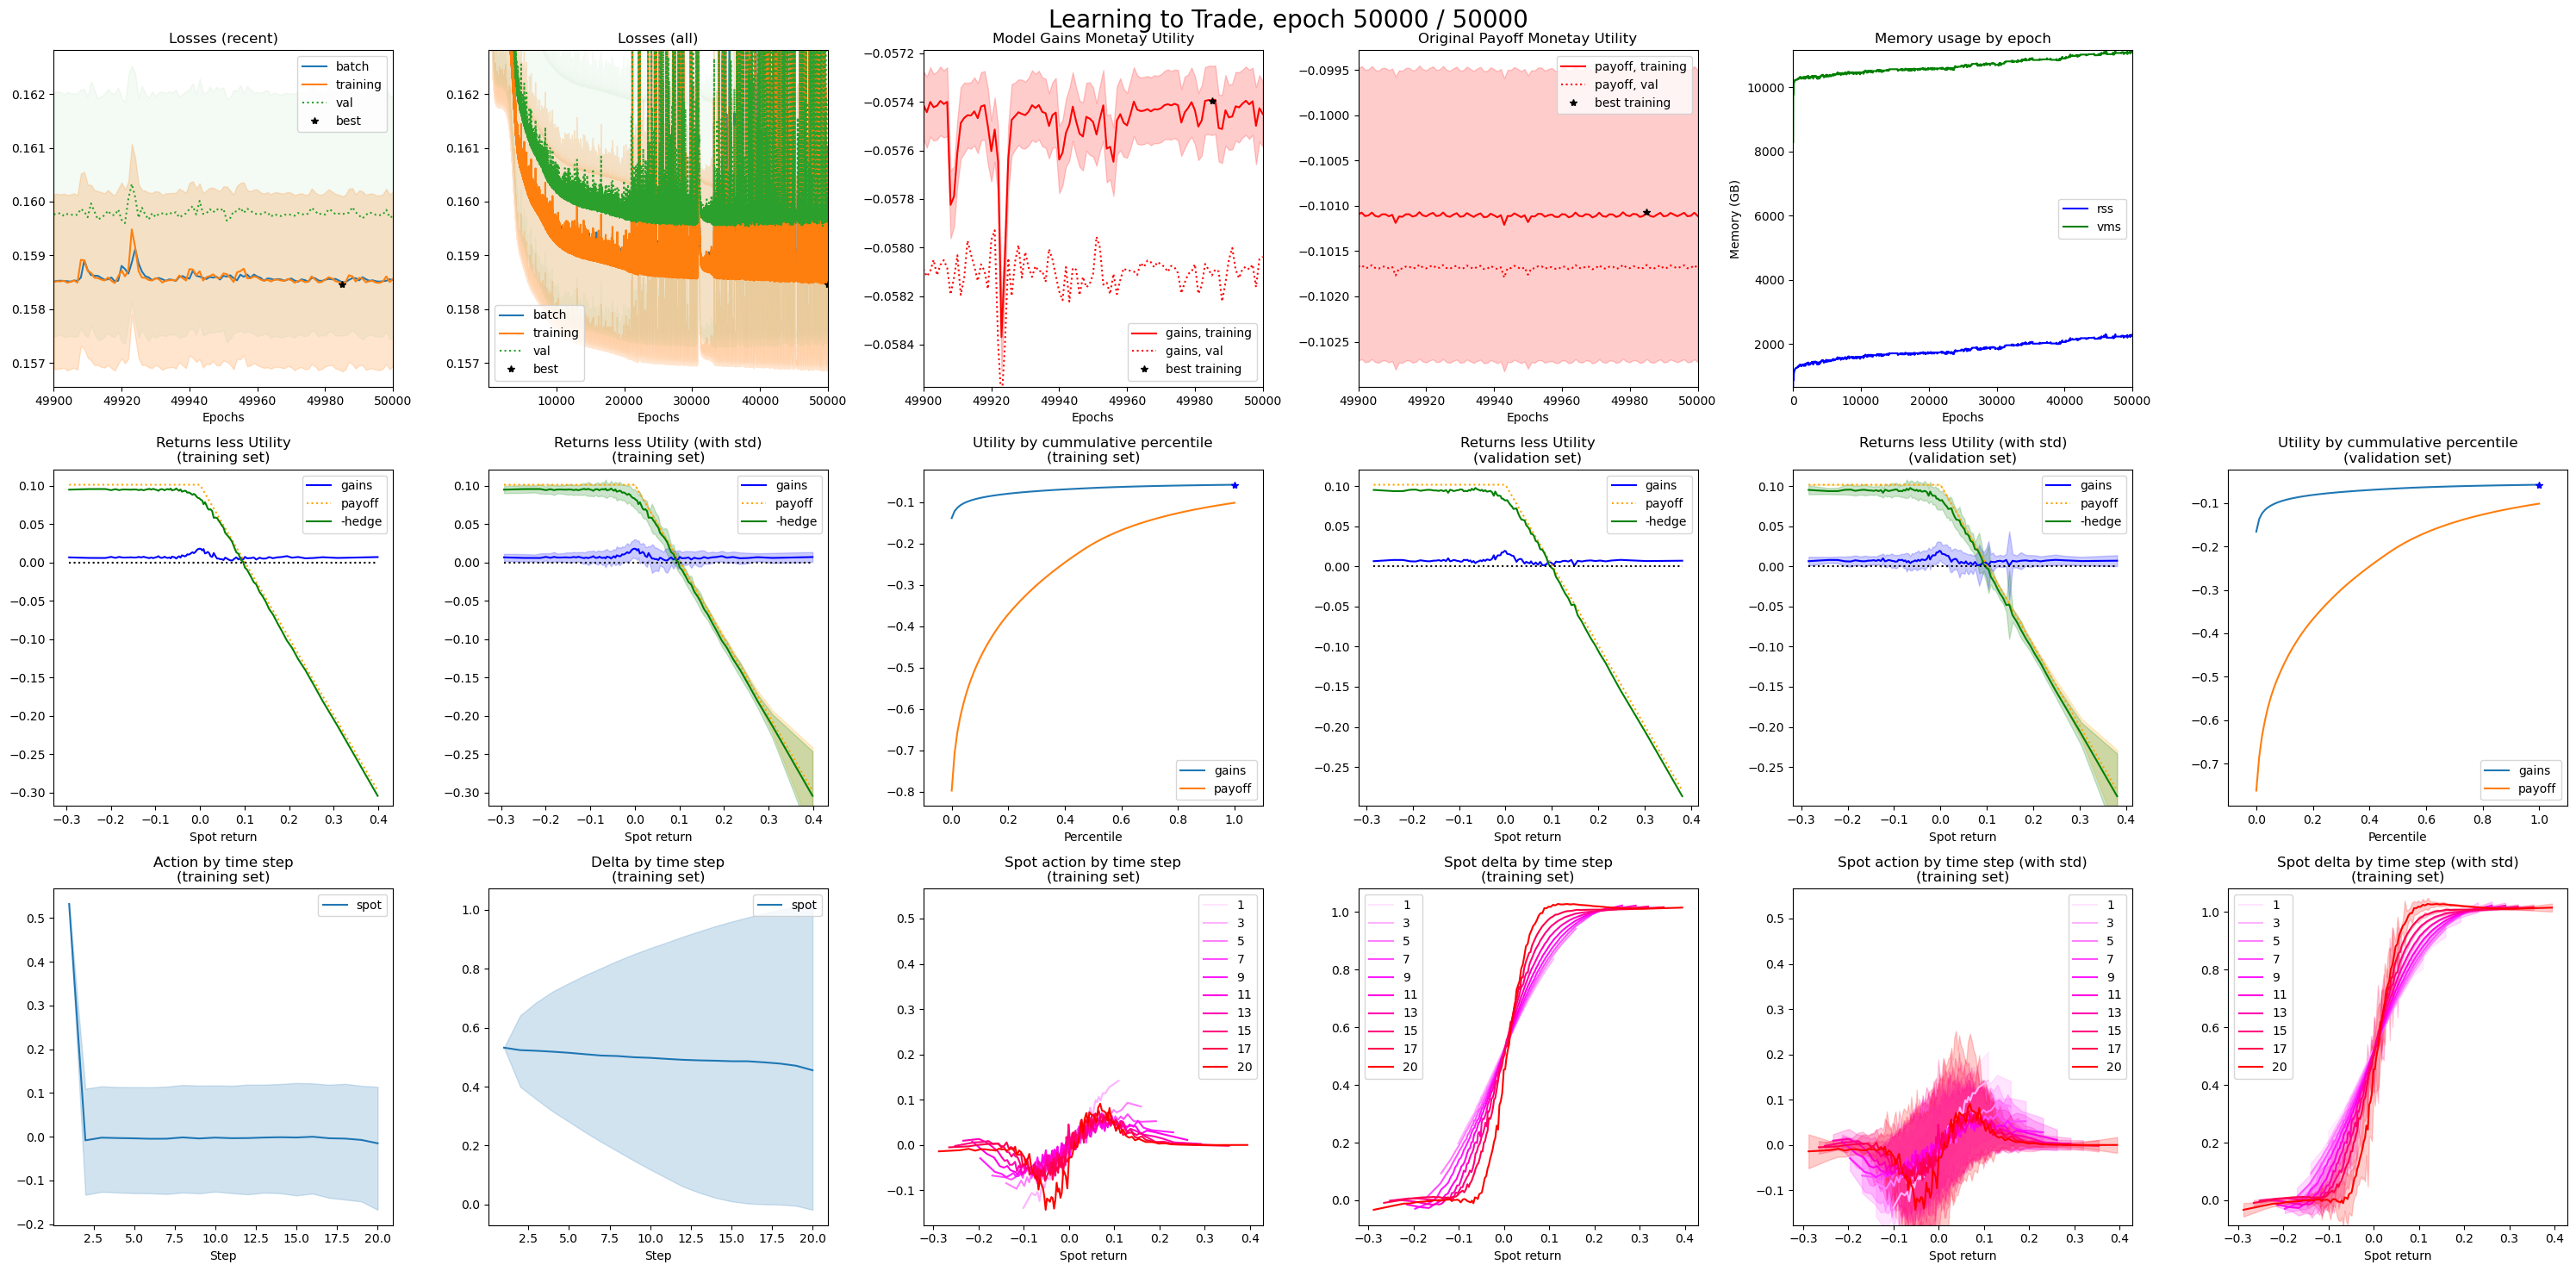

Training 50000/50000 epochs; 944 weights; 10000 samples; 5000 validation samples batch size 2000 | initial loss 1.56614 (0.0245614), training 0.158563 (0.00162224), best 0.158467 (0.0245614), batch 0.158543, val 0.159725 (0.00225688). Best epoch 49985; last cached 50000. | memory used: rss 2297.18M, vms 11127.4M | time elapsed 3:08:51; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 49985
 State of training until epoch 50000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/3654460ec08215c71e862f01bb5d3bbb.pck

Training terminated. Total time taken 12s


In [3]:
display(Markdown("## Deep Hedging in a Black \& Scholes World - Big Steps"))

# create world
world  = SimpleWorld_BS( config.world )
val_world  = world.clone(samples=world.nSamples//2)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

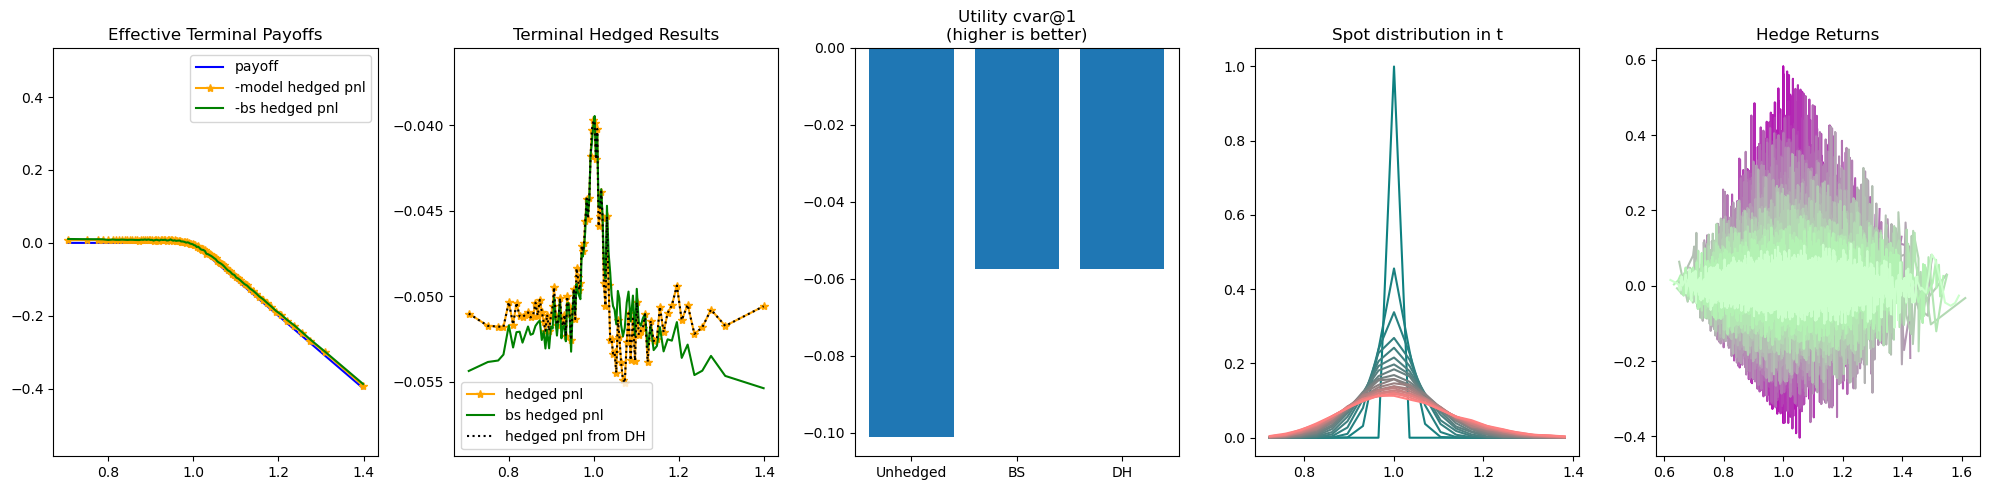

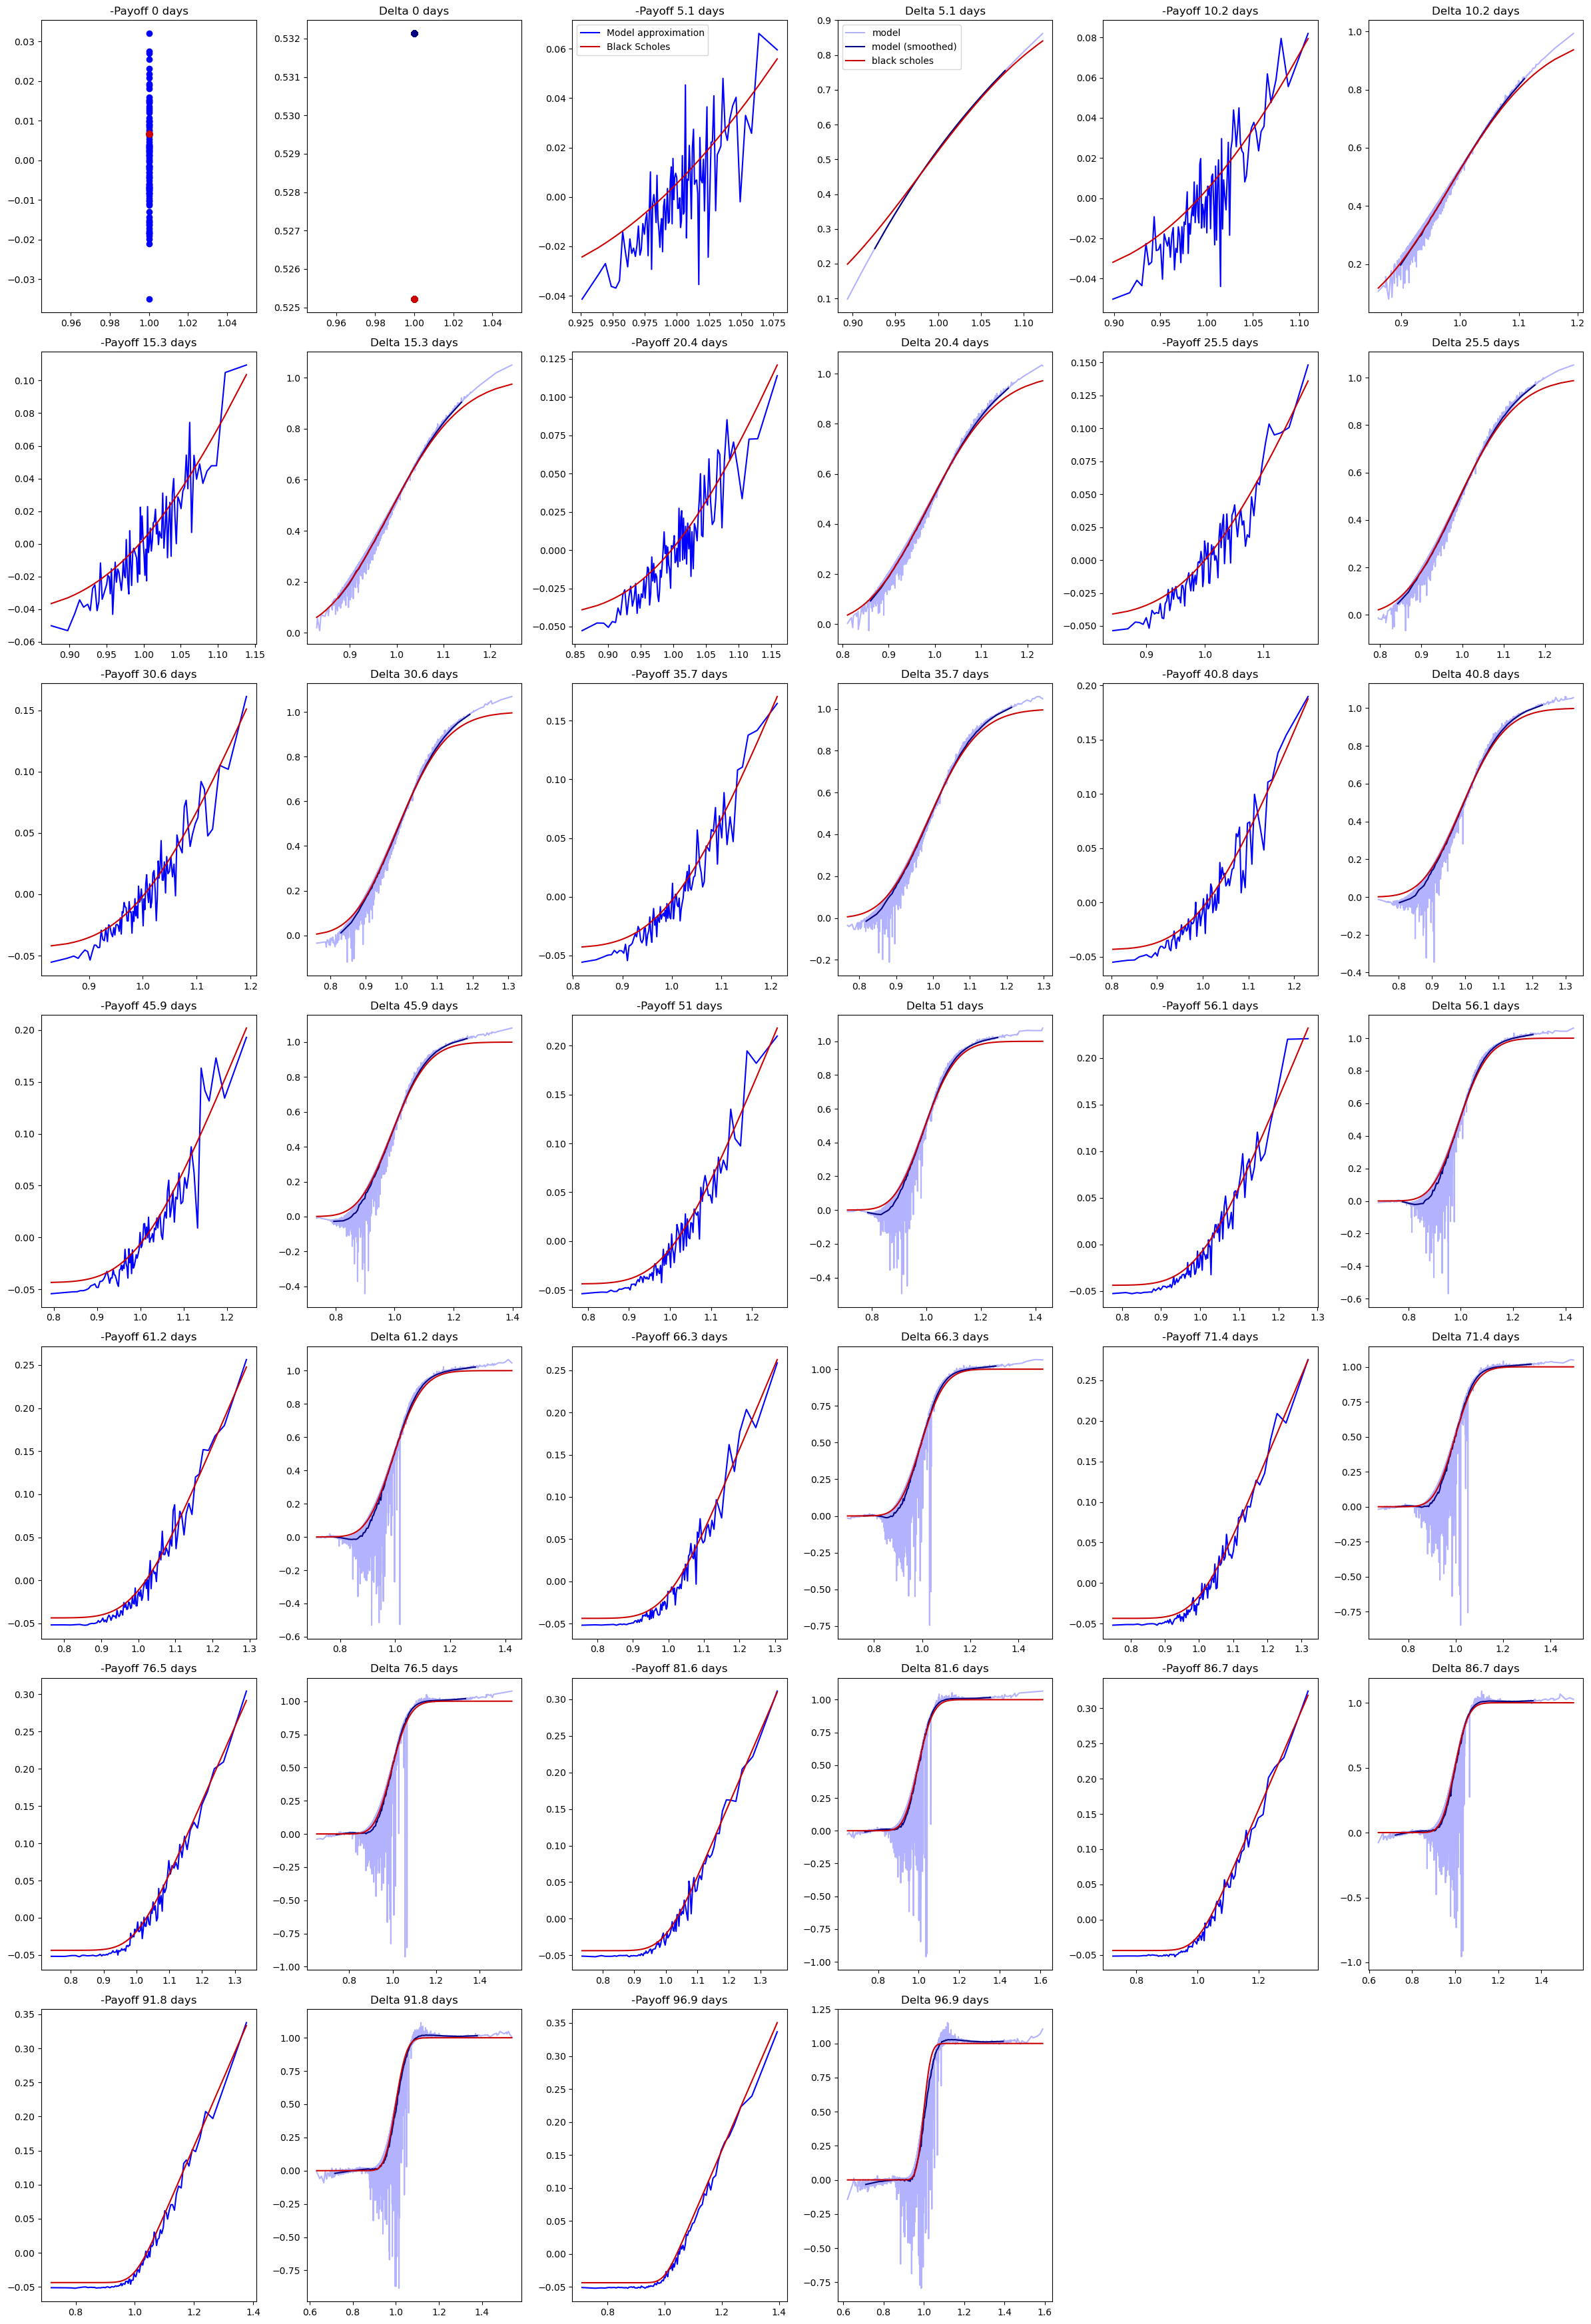

Running strategies ...done
Running tensorflow to compute utility of BS strategy ...done; result -0.0575835
Rendering now. Stand by.


In [4]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config )

## Deep Hedging in a Black \& Scholes World - Small Steps (this blew up before 26000)

Gym with 944 trainable weights compiled and initialized. Took 1s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c615e30e0c3e30a07e63f1cb4c173fba.pck'
Cache successfully loaded. Current epoch: 50000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c615e30e0c3e30a07e63f1cb4c173fba.pck was trained for 50000 epochs; you have asked to train fo

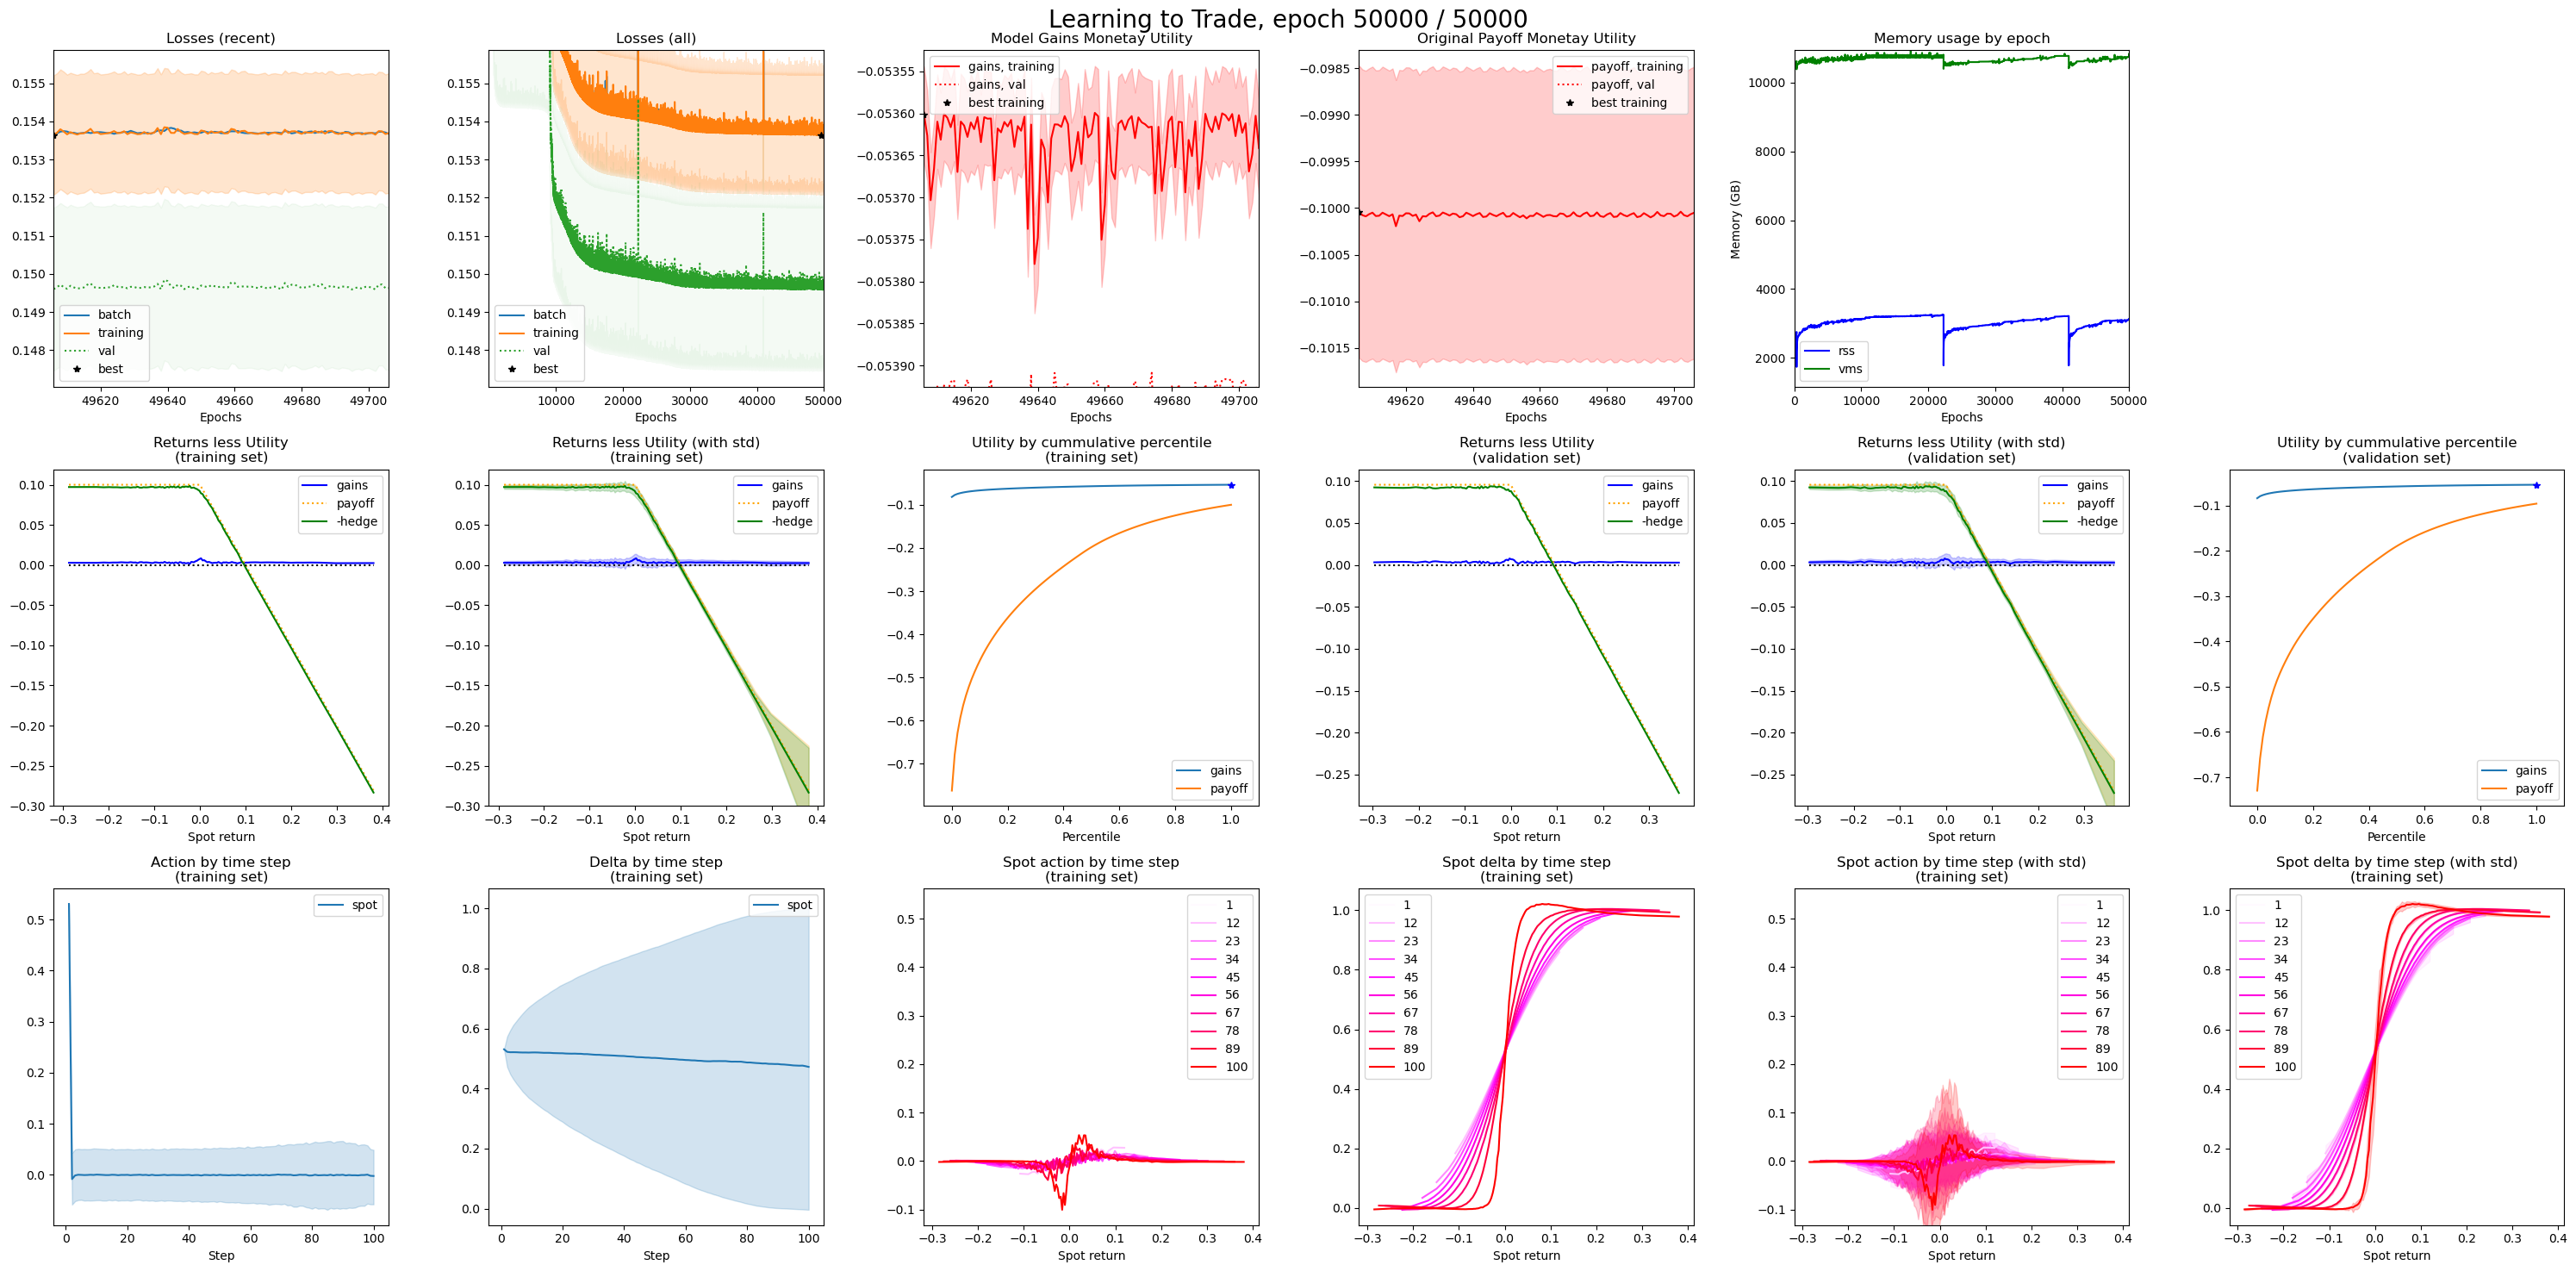

Training 50000/50000 epochs; 944 weights; 10000 samples; 5000 validation samples batch size 2000 | initial loss 4.44991 (0.0707802), training 0.153688 (0.00155865), best 0.15364 (0.0707802), batch 0.153719, val 0.149663 (0.00212786). Best epoch 49606; last cached 50000. | memory used: rss 3132.32M, vms 10773.4M | time elapsed 12:44:48; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 49606
 State of training until epoch 50000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c615e30e0c3e30a07e63f1cb4c173fba.pck

Training terminated. Total time taken 11s


In [6]:
display(Markdown("## Deep Hedging in a Black \& Scholes World - Small Steps (this blew up before 26000)"))

config_small_dt.trainer.caching.mode = "on"

# create world
world      = SimpleWorld_BS( config_small_dt.world )
val_world  = world.clone(samples=world.nSamples//2)

# create training environment
gym = VanillaDeepHedgingGym( config_small_dt.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config_small_dt.trainer )
config_small_dt.done()

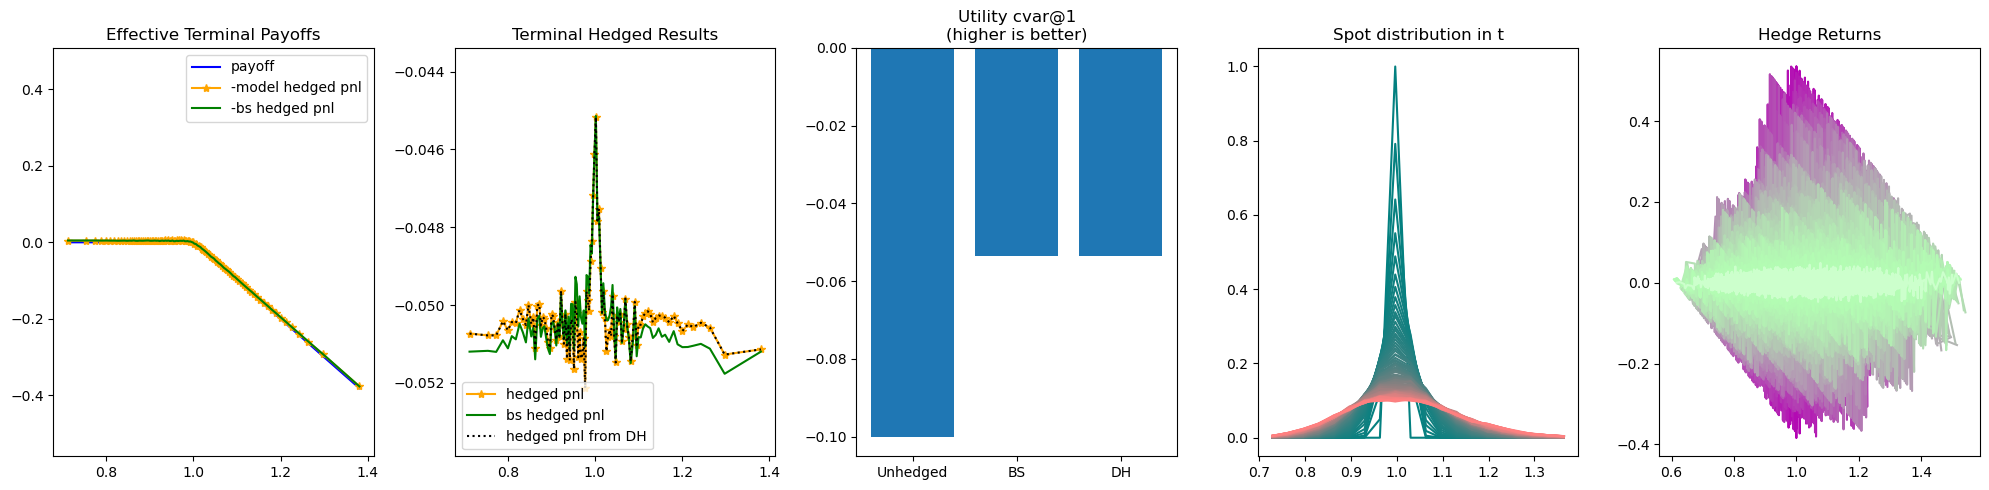

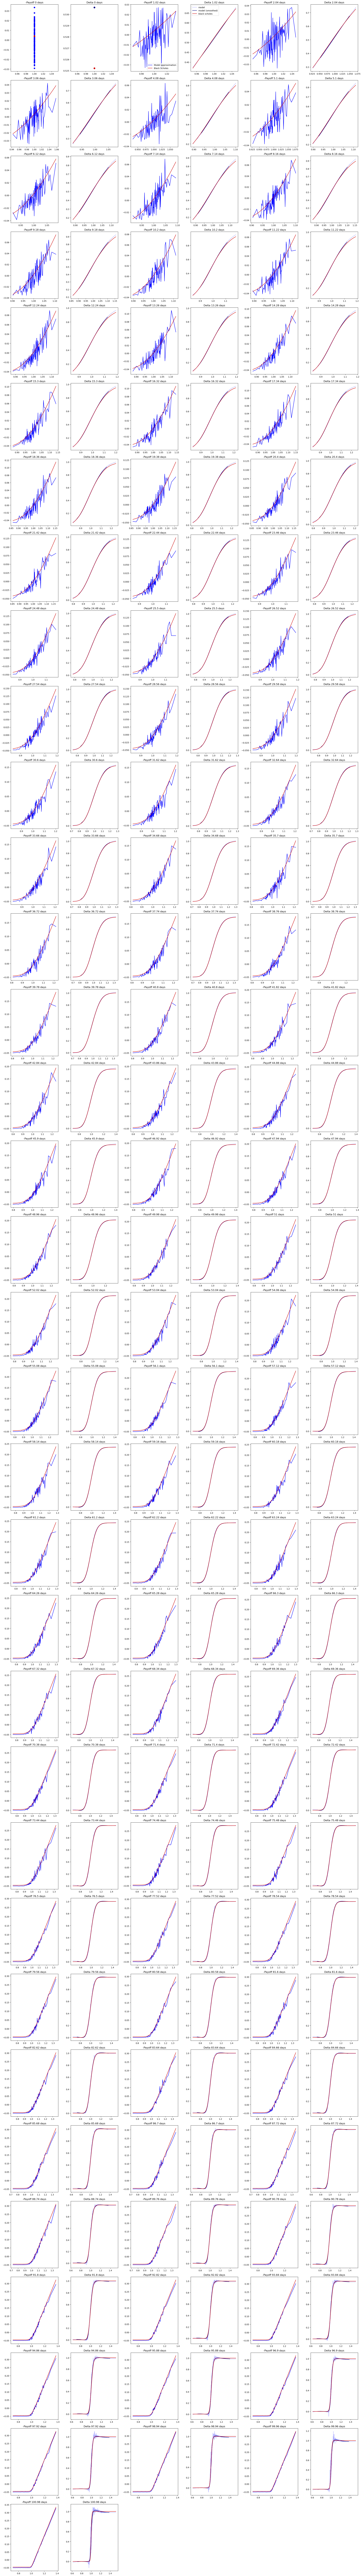

Running strategies ...

done
Running tensorflow to compute utility of BS strategy ...done; result -0.0535918
Rendering now. Stand by.


In [7]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config_small_dt )